## Happiness among developers
This is an attempt to understand what makes developers happy (as determined by their job satisfaction), with a definite agenda to look closely at education. I'm using three years of the Stack Overflow developer survey (2017-19), since these have good data dictionaries, large response sizes, and some overlap in their fields.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
%matplotlib inline

In [2]:
# Read in three years with good data dictionaries
# NOTE: This assumes data are in a subfolder of where the notebook is being run
df19 = pd.read_csv("data/survey_results_2019.csv", header=0, low_memory=False)
df18 = pd.read_csv("data/survey_results_2018.csv", header=0, low_memory=False)
df17 = pd.read_csv("data/survey_results_2017.csv", header=0, low_memory=False)

## Job satisfaction across surveys
Naturally, the job satisfaction question had a different rating scale each year. Fortunately, they can all be mapped to Likert scales with the same magnitude. If the distributions of responses are similar (enough), I might be able to look across years.

In [3]:
# The variable name, values, and scale all change each year 
print("2019:")
print(df19.groupby(['JobSat'])['JobSat'].count())
print("2018:")
print(df18.groupby(['JobSatisfaction'])['JobSatisfaction'].count())
print("2017:")
print(df17.groupby(['JobSatisfaction'])['JobSatisfaction'].count())

2019:
JobSat
Neither satisfied nor dissatisfied     8720
Slightly dissatisfied                 10752
Slightly satisfied                    24207
Very dissatisfied                      4857
Very satisfied                        22452
Name: JobSat, dtype: int64
2018:
JobSatisfaction
Extremely dissatisfied                 2482
Extremely satisfied                   12436
Moderately dissatisfied                6318
Moderately satisfied                  26005
Neither satisfied nor dissatisfied     4966
Slightly dissatisfied                  7057
Slightly satisfied                    10012
Name: JobSatisfaction, dtype: int64
2017:
JobSatisfaction
0.0      467
1.0      373
2.0      888
3.0     1635
4.0     1865
5.0     3749
6.0     4726
7.0     7969
8.0     8983
9.0     5573
10.0    4148
Name: JobSatisfaction, dtype: int64


In [4]:
# Map 2018 and 2019 to same scale as 2017 and reconcile variable names
dsat19 = {
    'Very dissatisfied': 0.,
    'Slightly dissatisfied': 2.5,
    'Neither satisfied nor dissatisfied': 5.,
    'Slightly satisfied': 7.5,
    'Very satisfied': 10.,
}
dsat18 = {
    'Extremely dissatisfied': 0.,
    'Moderately dissatisfied': 1*5/3,
    'Slightly dissatisfied': 2*5/3,
    'Neither satisfied nor dissatisfied': 5.,
    'Slightly satisfied': 4*5/3,
    'Moderately satisfied': 5*5/3,
    'Extremely satisfied': 10.,
}
df19['qJobSat'] = [dsat19.get(var, None) for var in df19.JobSat]
df18['qJobSat'] = [dsat18.get(var, None) for var in df18.JobSatisfaction]
df17['qJobSat'] = df17.JobSatisfaction

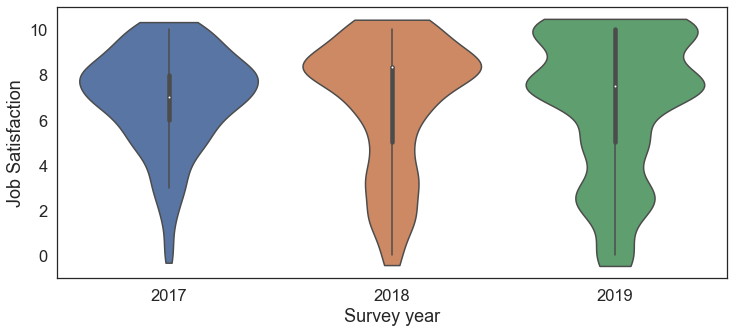

In [5]:
# Stack data to plot
df_qjs = pd.concat([
    pd.DataFrame({'year':2019, 'qJobSat':df19.qJobSat}).dropna(),
    pd.DataFrame({'year':2018, 'qJobSat':df18.qJobSat}).dropna(),
    pd.DataFrame({'year':2017, 'qJobSat':df17.qJobSat}).dropna(),
])

sns.set(style="white", font_scale=1.5)
plt.figure(figsize=(12, 5))
plt_qjs = sns.violinplot(
    y='qJobSat', x='year', hue='year', 
    data=df_qjs, bw=0.3, cut=0.5, dodge=False)
plt_qjs.set(xlabel="Survey year", ylabel="Job Satisfaction")
plt_qjs.legend_.remove()

plt.show();

Not as tight as I would like (more categories makes for a smoother function), but reasonabl eenough to give it a try. Do these look like ship designs from Master of Orion I to anyone else?

## Education levels and satisfaction
There's definitely an agenda here to try to litigate whether getting a PhD (or other doctorate) is worth it, at least for people in this field. Grouping respondents from 2017 by degree (as done in the Udacity nanodegree lectures) suggested people with doctorates were notably more satisfied with their jobs. Does this hold across years?
Fortunately, the levels are pretty consistent, so there's just some minor remapping to make the variables plot-friendly.

In [6]:
# The variable name, values, and scale all change each year 
print("2019:")
print(df19.groupby(['EdLevel'])['EdLevel'].count())
print("2018:")
print(df18.groupby(['FormalEducation'])['FormalEducation'].count())
print("2017:")
print(df17.groupby(['FormalEducation'])['FormalEducation'].count())

2019:
EdLevel
Associate degree                                                                       2938
Bachelor’s degree (BA, BS, B.Eng., etc.)                                              39134
I never completed any formal education                                                  553
Master’s degree (MA, MS, M.Eng., MBA, etc.)                                           19569
Other doctoral degree (Ph.D, Ed.D., etc.)                                              2432
Primary/elementary school                                                              1422
Professional degree (JD, MD, etc.)                                                     1198
Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)     8642
Some college/university study without earning a degree                                10502
Name: EdLevel, dtype: int64
2018:
FormalEducation
Associate degree                                                                       2970
Bachelor’s degre

In [7]:
# Give everyone the same names so we can actually plot this
dedu = {
    "Associate degree":"Assoc",
    "Bachelor’s degree (BA, BS, B.Eng., etc.)": "Bach",
    "Bachelor's degree": "Bach",
    "I never completed any formal education": "NoEd",
    "Master’s degree (MA, MS, M.Eng., MBA, etc.)": "Mast",
    "Master's degree": "Mast",
    "Other doctoral degree (Ph.D, Ed.D., etc.)": "Doc",
    "Doctoral degree": "Doc",
    "Primary/elementary school": "Prim",
    "Professional degree (JD, MD, etc.)": "Prof",
    "Professional degree": "Prof",
    "Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)": "Sec",
    "Secondary school": "Sec",
    "Some college/university study without earning a degree": "Some",
    "Some college/university study without earning a bachelor's degree": "Some",
}
df19['EdLvl'] = [dedu.get(var, None) for var in df19.EdLevel]
df18['EdLvl'] = [dedu.get(var, None) for var in df18.FormalEducation]
df17['EdLvl'] = [dedu.get(var, None) for var in df17.FormalEducation]

In [8]:
# Stack data to plot
df_edjs = pd.concat([
    pd.DataFrame({'year':2019, 'qJobSat':df19.qJobSat, 'EdLvl':df19.EdLvl}).dropna(),
    pd.DataFrame({'year':2018, 'qJobSat':df18.qJobSat, 'EdLvl':df18.EdLvl}).dropna(),
    pd.DataFrame({'year':2017, 'qJobSat':df17.qJobSat, 'EdLvl':df17.EdLvl}).dropna(),
])
df_edjs['EdLvl'] = df_edjs['EdLvl'].astype('category')
df_edjs['EdLvl'] = df_edjs.EdLvl.cat.set_categories([
    'NoEd', 'Prim', 'Sec', 'Some', 'Assoc', 'Bach', 'Mast', 'Doc', 'Prof'
     ], ordered=True)


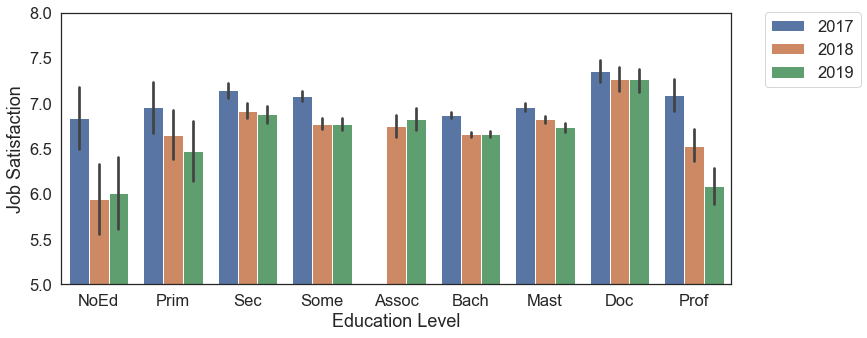

In [9]:
sns.set(style="white", font_scale=1.5)
plt.figure(figsize=(12, 5))
plt_edjs = sns.barplot(y='qJobSat', x='EdLvl', hue='year', data=df_edjs)
plt_edjs.set(ylim=(5,8), xlabel="Education Level", ylabel="Job Satisfaction")
#plt_edjs.legend_.remove()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show();

Two neat things here:
* Doctors are indeed consistently more satisfied than those with different
levels of education
* Other groups are less consistent (note the poor professional degree-holders)

Now, how much of this is the degree as opposed to other factors?

## Predicting job satisfaction
There was a good bit of behind-the-scenes work to identify variables that were at least nominally consistent across survey years. It's still not plausible to analyze everything together, but I can look at the three years in parallel and see what similarities/differences I encounter.

Note that there are a few irregularities among the years:
* 2018 was missing a question about working remotely, but given how topical that question is right now, I figured I'd leave it in
* Each year, there was a separate question that I interpreted as relating to the respondent's self-evaluation:
    * 2017 - Compared to your estimate of your own market value, do you think you are over/underpaid?
    * 2018 - To what extent do you agree with the statement "I'm not as good at programming as most of my peers"
    * 2019 - For the specific work you do and your experience, how do you rate your level of competence?
    
There are a few functions I'll use further down that will make life easier. This seems as good a place as any to keep them, so the subsequent code is easier to read (and it's clearer what is straight-up repetition).

In [10]:
def lang_cnt(df, var, sep=";"):
    '''Get number of languages/databases known/desired'''
    
    cnt = [lang.count(sep)+1 if isinstance(lang,str) else 0 for lang in df[var]]
    return cnt


def coef_weights(mod, dat):
    '''Sort coefficients in a linear model by magnitude
    Arguments:
        mod - fitted sklearn linear model
        dat - X matrix that could be fed into mod, used only to get
            the list of columns
    Returns:
        coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = dat.columns
    coefs_df['coefs'] = mod.coef_
    coefs_df['abs_coefs'] = np.abs(coefs_df['coefs'])
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df


def make_year_int(yrs_str):
    '''Convert a string year into an int, 
    because I do not see an easier way right now'''
    d_yr = {
        'Less than 1 year':0,
        'More than 50 years':51,
        np.nan:np.nan
    }
    yrs = []
    for yr in yrs_str:
        try:
            yrs.append(int(yr))
        except:
            yrs.append(d_yr[yr])
    return yrs

### 2017

In [11]:
# Restrict to columns common across surveys
cols17 = [
    'qJobSat', "ProgramHobby", "EmploymentStatus", "University", 
    "FormalEducation", "CompanySize", "YearsProgram", "YearsCodedJob",
    "JobSeekingStatus", "LastNewJob", "Salary", "HomeRemote", "Overpaid",
    "HaveWorkedLanguage", "WantWorkLanguage", "HaveWorkedDatabase",
    "WantWorkDatabase", "StackOverflowCommunity"
]

df17_mod = df17[cols17].dropna(subset=['qJobSat'], axis=0)

In [12]:
# Turn some categorical variables quantitative
comp17 = {
    '10,000 or more employees':15000,
    '10 to 19 employees': 15,
    '20 to 99 employees': 60, 
    'Fewer than 10 employees': 5,
    '5,000 to 9,999 employees': 7500,
    '100 to 499 employees': 300,
    '1,000 to 4,999 employees': 3000, 
    '500 to 999 employees': 750,
    'Just me - I am a freelancer, sole proprietor, etc.': 1,
    "I don't know": None,
    'I prefer not to answer': None
    }
years17 = {
    '1 to 2 years': 1.5,
    '10 to 11 years': 10.5,
    '11 to 12 years': 11.5,
    '12 to 13 years': 12.5,
    '13 to 14 years': 13.5,
    '14 to 15 years': 14.5,
    '15 to 16 years': 15.5,
    '16 to 17 years': 16.5,
    '17 to 18 years': 17.5,
    '18 to 19 years': 18.5,
    '19 to 20 years': 19.5,
    '2 to 3 years': 2.5,
    '20 or more years': 21,
    '3 to 4 years': 3.5,
    '4 to 5 years': 4.5,
    '5 to 6 years': 5.5,
    '6 to 7 years': 6.5,
    '7 to 8 years': 7.5,
    '8 to 9 years': 8.5,
    '9 to 10 years': 9.5,
    'Less than a year': 0.5,
    }
df17_mod['qCompSize'] = [comp17.get(var, None) for var in df17_mod.CompanySize]
df17_mod['qYrsProg'] = [years17.get(var, None) for var in df17_mod.YearsProgram]
df17_mod['qYrsCodeJob'] = [years17.get(var, None) for var in df17_mod.YearsCodedJob]

In [13]:
# Get counts of languges known/used and desired

df17_mod['lang_have_cnt'] = lang_cnt(df17_mod, "HaveWorkedLanguage")
df17_mod['lang_want_cnt'] = lang_cnt(df17_mod, "WantWorkLanguage")
df17_mod['dbs_have_cnt'] = lang_cnt(df17_mod, "HaveWorkedDatabase")
df17_mod['dbs_want_cnt'] = lang_cnt(df17_mod, "WantWorkDatabase")

In [14]:
# Get salary nulls, then clean up quantitative variables
df17_mod['salary_null'] = [0 if sal else 1 for sal in df17_mod.Salary]
# Split quant and cat variables
df17_mod_qnt = df17_mod.loc[:,[
    'qJobSat', 'lang_have_cnt', 'lang_want_cnt', 
    'dbs_have_cnt', 'dbs_want_cnt', 
    'qYrsProg', 'qYrsCodeJob', 'qCompSize',
    'Salary', 'salary_null'
    ]].copy()

for col in df17_mod_qnt:
    df17_mod_qnt[col].fillna((df17_mod_qnt[col].mean()), inplace=True)

In [15]:
# Get categorical variables, make dummies, and remove rare ones
cut = ["JobSeekingStatus",]
df17_mod_cat = df17_mod.loc[:,[
    "ProgramHobby", "EmploymentStatus", "University", 
    "FormalEducation",  "LastNewJob", "HomeRemote", 
    "Overpaid", "StackOverflowCommunity",
    "JobSeekingStatus"
    ]].copy().replace({pd.np.nan:None})

df17_mod_dum = pd.get_dummies(
    df17_mod_cat, prefix=df17_mod_cat.columns, prefix_sep="_", 
    dummy_na=True, drop_first=True)

df17_mod_dum = df17_mod_dum.loc[:, df17_mod_dum.mean() >= 0.01]

In [16]:
# Combine categorical and quantitative variables
df17_mod_rdy = pd.concat([df17_mod_qnt, df17_mod_dum], axis=1)

In [17]:
# Split data, train model, see how it did

y17 = df17_mod_rdy['qJobSat'].copy()
X17 = df17_mod_rdy.drop(['qJobSat'], axis=1).copy()
# #Split into train and test
X17_train, X17_test, y17_train, y17_test = train_test_split(X17, y17, test_size = .30, random_state=171819) 

lm17 = LinearRegression(normalize=True) 
lm17.fit(X17_train, y17_train) #Fit

# Test training
pred17_train = lm17.predict(X17_train)
pred17_test = lm17.predict(X17_test)
print("Training R2: {}".format(round(r2_score(y17_train, pred17_train),3)))
print("Testing R2: {}".format(round(r2_score(y17_test, pred17_test),3)))

Training R2: 0.167
Testing R2: 0.16


In [18]:
# Look at coefficients ranked by magnitude
coef_df = coef_weights(lm17, X17_train)
coef_df.head(22)

,est_int,coefs,abs_coefs
43,JobSeekingStatus_I am not interested in new jo...,3.283774,3.283774
45,JobSeekingStatus_nan,2.023221,2.023221
44,"JobSeekingStatus_I'm not actively looking, but...",1.834107,1.834107
33,Overpaid_Greatly underpaid,-1.200157,1.200157
8,salary_null,0.509611,0.509611
32,HomeRemote_Never,-0.367190,0.367190
36,Overpaid_Somewhat underpaid,-0.311259,0.311259
17,FormalEducation_Doctoral degree,0.296455,0.296455
41,StackOverflowCommunity_Strongly disagree,-0.280849,0.280849
38,StackOverflowCommunity_Disagree,-0.272493,0.272493


### 2018

In [19]:
# Restrict to columns common across surveys
cols18 = [
    'qJobSat', "Hobby", "OpenSource", "Employment", "Student",
    "FormalEducation", "CompanySize", "YearsCoding", "YearsCodingProf",
    "JobSearchStatus", "LastNewJob", "ConvertedSalary",
    "AgreeDisagree3", "LanguageWorkedWith", "LanguageDesireNextYear",
    "DatabaseWorkedWith", "DatabaseDesireNextYear", 
    "StackOverflowConsiderMember"
    ]
    
df18_mod = df18[cols18].dropna(subset=['qJobSat'], axis=0)

In [20]:
# Turn some categorical variables quantitative
years18 = {
    '0-2 years': 1.5,
    '3-5 years': 4.5,
    '6-8 years': 7.5,
    '9-11 years': 10.5,
    '12-14 years': 13.5,
    '15-17 years': 16.5,
    '18-20 years': 19.5,
    '21-23 years': 22.5,
    '24-26 years': 25.5,
    '27-29 years': 28.5,
    '30 or more years': 31,
    }
# We can reuse the company size dictionary from 2017
df18_mod['qCompSize'] = [comp17.get(var, None) for var in df18_mod.CompanySize]
df18_mod['qYrsProg'] = [years18.get(var, None) for var in df18_mod.YearsCoding]
df18_mod['qYrsCodeJob'] = [years18.get(var, None) for var in df18_mod.YearsCodingProf]

In [21]:
# Get counts of languages used/wanted
df18_mod['lang_have_cnt'] = lang_cnt(df18_mod, "LanguageWorkedWith")
df18_mod['lang_want_cnt'] = lang_cnt(df18_mod, "LanguageDesireNextYear")
df18_mod['dbs_have_cnt'] = lang_cnt(df18_mod, "DatabaseWorkedWith")
df18_mod['dbs_want_cnt'] = lang_cnt(df18_mod, "DatabaseDesireNextYear")

In [22]:
# Get salary nulls, then clean up quantitative variables
df18_mod['salary_null'] = [0 if sal else 1 for sal in df18_mod.ConvertedSalary]
# Split quant and cat variables
df18_mod_qnt = df18_mod.loc[:,[
    'qJobSat', 'lang_have_cnt', 'lang_want_cnt', 
    'dbs_have_cnt', 'dbs_want_cnt', 
    'qCompSize', 'qYrsProg', 'qYrsCodeJob',
    'ConvertedSalary', 'salary_null'
    ]].copy()

for col in df18_mod_qnt:
    df18_mod_qnt[col].fillna((df18_mod_qnt[col].mean()), inplace=True)

In [23]:
# Get categorical variables, make dummies, and remove rare ones
df18_mod_cat = df18_mod.loc[:,[
    "Hobby", "OpenSource", "Employment", "Student",
    "FormalEducation", "JobSearchStatus", "LastNewJob",
    "AgreeDisagree3", "StackOverflowConsiderMember",
#    "CompanySize", "YearsCoding", "YearsCodingProf"
    ]].copy().replace({pd.np.nan:None})

df18_mod_dum = pd.get_dummies(
    df18_mod_cat, prefix=df18_mod_cat.columns, prefix_sep="_", 
    dummy_na=True, drop_first=True)

df18_mod_dum = df18_mod_dum.loc[:, df18_mod_dum.mean() >= 0.01]

In [24]:
# Combine categorical and quantitative variables
df18_mod_rdy = pd.concat([df18_mod_qnt, df18_mod_dum], axis=1)

In [25]:
# Split data, train model, see how it did

y18 = df18_mod_rdy['qJobSat'].copy()
X18 = df18_mod_rdy.drop(['qJobSat'], axis=1).copy()
# #Split into train and test
X18_train, X18_test, y18_train, y18_test = train_test_split(X18, y18, test_size = .30, random_state=171819) 

lm18 = LinearRegression(normalize=True) 
lm18.fit(X18_train, y18_train) #Fit

# Test training
pred18_train = lm18.predict(X18_train)
pred18_test = lm18.predict(X18_test)
print("Training R2: {}".format(round(r2_score(y18_train, pred18_train),3)))
print("Testing R2: {}".format(round(r2_score(y18_test, pred18_test),3)))

Training R2: 0.148
Testing R2: 0.147


In [26]:
# Look at coefficients ranked by magnitude
coef_df = coef_weights(lm18, X18_train)
coef_df.head(10)

,est_int,coefs,abs_coefs
23,JobSearchStatus_I am not interested in new job...,3.584447,3.584447
24,"JobSearchStatus_I’m not actively looking, but ...",2.030880,2.030880
18,"FormalEducation_Other doctoral degree (Ph.D, E...",0.457368,0.457368
8,salary_null,-0.359303,0.359303
12,"Employment_Independent contractor, freelancer,...",0.321489,0.321489
30,AgreeDisagree3_Strongly agree,-0.320931,0.320931
10,OpenSource_Yes,0.234444,0.234444
34,StackOverflowConsiderMember_Yes,0.223856,0.223856
17,"FormalEducation_Master’s degree (MA, MS, M.Eng...",0.194279,0.194279
27,LastNewJob_More than 4 years ago,-0.186615,0.186615


### 2019

In [27]:
# Restrict to columns common across surveys
cols19 = [
    'qJobSat', "Hobbyist", "OpenSourcer", "Employment", "Student",
    "EdLevel", "OrgSize", "YearsCode", "YearsCodePro",
    "JobSeek", "LastHireDate", "ConvertedComp", "WorkRemote",
    "ImpSyn", "LanguageWorkedWith", "LanguageDesireNextYear",
    "DatabaseWorkedWith", "DatabaseDesireNextYear", 
    "SOComm"
    ]
    
df19_mod = df19[cols19].dropna(subset=['qJobSat'], axis=0)

In [28]:
# We can still use the company size dictionary defined for 2017
df19_mod['qCompSize'] = [comp17.get(var, None) for var in df19_mod.OrgSize]
# Need to use a function to convert yars thogh
df19_mod['qYrsProg'] = make_year_int(df19_mod.YearsCode)
df19_mod['qYrsCodeJob'] = make_year_int(df19_mod.YearsCodePro)

In [29]:
# Count languages used and desired
df19_mod['lang_have_cnt'] = lang_cnt(df19_mod, "LanguageWorkedWith")
df19_mod['lang_want_cnt'] = lang_cnt(df19_mod, "LanguageDesireNextYear")
df19_mod['dbs_have_cnt'] = lang_cnt(df19_mod, "DatabaseWorkedWith")
df19_mod['dbs_want_cnt'] = lang_cnt(df19_mod, "DatabaseDesireNextYear")

In [30]:
# Get salary nulls, then clean up quantitative variables
df19_mod['salary_null'] = [0 if sal else 1 for sal in df19_mod.ConvertedComp]
# Split quant and cat variables
df19_mod_qnt = df19_mod.loc[:,[
    'qJobSat', 'lang_have_cnt', 'lang_want_cnt', 
    'dbs_have_cnt', 'dbs_want_cnt', 
    'qCompSize', 'qYrsProg', 'qYrsCodeJob',
    'ConvertedComp', 'salary_null'
    ]].copy()

for col in df19_mod_qnt:
    df19_mod_qnt[col].fillna((df19_mod_qnt[col].mean()), inplace=True)

In [31]:
# Get categorical variables, make dummies, and remove rare ones
df19_mod_cat = df19_mod.loc[:,[
    "Hobbyist", "OpenSourcer", "Employment", "Student",
    "EdLevel", "JobSeek", "LastHireDate",
    "WorkRemote", "ImpSyn", "SOComm",
    ]].copy().replace({pd.np.nan:None})

df19_mod_dum = pd.get_dummies(
    df19_mod_cat, prefix=df19_mod_cat.columns, prefix_sep="_", 
    dummy_na=True, drop_first=True)

df19_mod_dum = df19_mod_dum.loc[:, df19_mod_dum.mean() >= 0.01]

In [32]:
# Combine categorical and quantitative variables
df19_mod_rdy = pd.concat([df19_mod_qnt, df19_mod_dum], axis=1)

In [33]:
# Split data, train model, see how it did

y19 = df19_mod_rdy['qJobSat'].copy()
X19 = df19_mod_rdy.drop(['qJobSat'], axis=1).copy()
# #Split into train and test
X19_train, X19_test, y19_train, y19_test = train_test_split(X19, y19, test_size = .30, random_state=171819) 

lm19 = LinearRegression(normalize=True) 
lm19.fit(X19_train, y19_train) #Fit

# Test training
pred19_train = lm19.predict(X19_train)
pred19_test = lm19.predict(X19_test)
print("Training R2: {}".format(round(r2_score(y19_train, pred19_train),3)))
print("Testing R2: {}".format(round(r2_score(y19_test, pred19_test),3)))

Training R2: 0.177
Testing R2: 0.173


In [34]:
# Look at coefficients ranked by magnitude
coef_df = coef_weights(lm19, X19_train)
coef_df.head(10)

,est_int,coefs,abs_coefs
25,JobSeek_I am not interested in new job opportu...,4.084664,4.084664
26,"JobSeek_I’m not actively looking, but I am ope...",2.214740,2.214740
41,ImpSyn_Far below average,-1.050541,1.050541
38,ImpSyn_A little below average,-0.787669,0.787669
33,WorkRemote_It's complicated,-0.507262,0.507262
21,"EdLevel_Professional degree (JD, MD, etc.)",-0.437914,0.437914
35,WorkRemote_Less than once per month / Never,-0.348383,0.348383
20,"EdLevel_Other doctoral degree (Ph.D, Ed.D., etc.)",0.327978,0.327978
39,ImpSyn_Average,-0.293757,0.293757
30,LastHireDate_NA - I am an independent contract...,0.291426,0.291426


Okay, that was a lot! Kind of a mixed bag, but let's head to Medium to write this up.